## Demo: Expected Free Energy minimization for controlling a Duffing oscillator

This project considers a [Duffing oscillator](hkps://en.wikipedia.org/wiki/Duffing_equation), a driven damped harmonic oscillator with a cubic nonlinearity in its spring stiffness component. The continuous-time dynamics of the system are:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} + c \frac{d x(t)}{dt} + a x(t) + b x^3(t) =&\ u(t) + w(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$

where
$$\begin{align}
m     =&\ \text{mass} \\
c     =&\ \text{damping} \\
a     =&\ \text{linear stiffness} \\
b     =&\ \text{nonlinear stiffness} \\
y(t)    =&\ \text{observation (displacement)} \\
x(t)    =&\ \text{state (displacement)} \\
u(t)    =&\ \text{force} \\
v(t)    =&\ \text{measurement noise} \\
w(t)    =&\ \text{process noise}
\end{align}$$

The process noise is a Wiener process, where the increment is Gaussian distributed $w(t) \sim \mathcal{N}(0, \zeta^{-1}dt)$ with $\zeta$ representing the precision of the process. The measurement noise is also a Wiener process, with $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$ and $\xi$ as precision parameter.

We cast this to the following discrete-time system:

$$\begin{align}
x_k =&\ \theta_1 x_{k-1} + \theta_2 x_{k-1}^3 + \theta_3 x_{k-2} + \eta u_k + w_k \\
y_k =&\ x_k + e_k
\end{align}$$

where the coefficients $\theta = (\theta_1, \dots, \theta_3)$ and $\eta$ are nonlinear combinations of the physical parameters (i.e. mass, damping and stiffness).

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating environment at `C:\Users\kouww\OneDrive - Sioux Group B.V\Demos\Bayesian controllers\Project.toml`


In [2]:
using Plots
pyplot()
viz = true;

### Simulation environment

In [3]:
# Dynamical parameters
mass = 1.2
damping = 0.4
stiffness_lin = 0.9
stiffness_nnl = 0.8

# Process noise precision
ζ_true = 1e4

# Measurement noise precision
ξ_true = 1e3

# Pack parameters
sys_params = (mass, damping, stiffness_lin, stiffness_nnl, ζ_true, ξ_true);

# State transition coefficients
θ1 = (2*mass + damping - stiffness_lin)/(mass + damping)
θ2 = -stiffness_nnl/(mass + damping)
θ3 = -mass/(mass + damping)
θ_true = Array{Float64}([θ1, θ2, θ3])

# Control coefficient
η_true = 1/(mass + damping)

# Pack substituted variables
subs_params = (θ_true, η_true, ζ_true, ξ_true);

In [4]:
function sim_sys(input, state, sys_params)
   "Simulate dynamic system"
    
    # Unpack state
    x_kmin1, x_kmin2 = state
    
    # Unpack system parameters
    m,c,a,b,ζ,ξ = sys_params
    
    # Draw noises
    w_k = sqrt(inv(ζ))*randn(1,)[1]
    v_k = sqrt(inv(ξ))*randn(1,)[1]
    
    # State transition
    x_k = (2*m + c - a)/(m+c)*x_kmin1 + (-b)/(m+c)*x_kmin1^3 + -m/(m+c)*x_kmin2 + 1/(m+c)*input + w_k
    
    # Generate observation
    y_k = x_k + v_k
    
    return y_k, x_k    
end

sim_sys (generic function with 1 method)

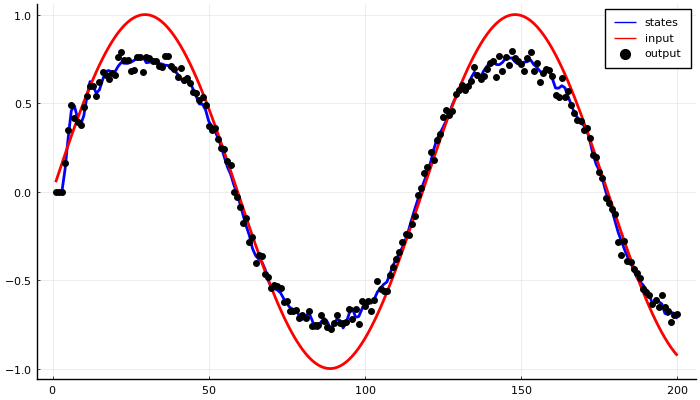

In [5]:
# Test simulation environment

# Time
T = 200

# Input signal
input = sin.((1:T)./ (6*π))

# Preallocate arrays
states = zeros(T,)
output = zeros(T,)

for k = 4:T
    output[k], states[k] = sim_sys(input[k], [states[k-1], states[k-2]], sys_params)
end

p100 = plot(1:T, states, linewidth=2, color="blue", label="states", size=(700,400))
plot!(1:T, input, linewidth=2, color="red", label="input", size=(700,400))
scatter!(1:T, output, color="black", label="output")

In [6]:
savefig(p100, "figures/example-input-output_seq1.png")
savefig(p100, "figures/example-input-output_seq1.pdf")

## Model

We cast the above system into matrix form:

$$ \underbrace{\begin{bmatrix} x_{k} \\ x_{k-1} \end{bmatrix}}_{z_k} = \underbrace{\begin{bmatrix} 0 & 0 \\ 1 & 0 \end{bmatrix}}_{S} \underbrace{\begin{bmatrix} x_{k-1} \\ x_{k-2} \end{bmatrix}}_{z_{k-1}} + \underbrace{\begin{bmatrix} 1 \\ 0 \end{bmatrix}}_{s} g(\theta, z_{k-1}) + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, ,$$

with $g(\theta, z_{k-1}) = \theta_1 x_{k-1} + \theta_2 x_{k-2}$ and $\tilde{w}_k \sim \mathcal{N}(0, \zeta^{-1})$. The system is now a nonlinear autoregressive process:

$$z_k = f(\theta, z_{k-1}, \eta, u_k) + \tilde{w}_k$$

where $f(\theta, z_{k-1}, \eta, u_k) = S z_{k-1} + s g(\theta, z_{k-1}) + s \eta u_k$.

### Likelihood

Integrating out $\tilde{w}_t$ and $v_t$ produces a Gaussian state transition node:

$$\begin{align}
z_k \sim&\ \mathcal{N}(f(\theta, z_{k-1}, \eta, u_k), V(\zeta)) \\
y_k \sim&\ \mathcal{N}(s^{\top} z_k, \xi^{-1}) \, ,
\end{align}$$

where $V(\zeta) = \begin{bmatrix} \zeta^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $W(\zeta) = V(\zeta)^{-1} = \begin{bmatrix} \zeta & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

### Approximating the nonlinearity

The nonlinearity is approximated using a first-order Taylor expansion;

$$ g(\theta, x) = g(m_{\theta}, m_x) + J_{x}(m_{\theta}, m_x)^{\top}(x - m_x) + J_{\theta}(m_{\theta}, m_x)^{\top}(\theta - m_{\theta}) \, ,$$

where $J_x$ denotes the partial derivative of $g$ with respect to $x$ and $J_{\theta}$ w.r.t. $\theta$. Note that our current $g$ is linear in $\theta$ and one could argue that the approximation is unnecessary. However, this form is more general and the first-order Taylor is exact anyway.

### Priors

We choose the following priors:

$$\begin{align}
p(\theta) = \text{Normal}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \text{Normal}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\zeta)= \text{Gamma}(a^{0}_\zeta, b^{0}_\zeta) \, , \quad
p(\xi)= \text{Gamma}(a^{0}_\xi, b^{0}_\xi) \, .
\end{align}$$

### Recognition model

The recognition model will follow the generative model:

$$\begin{align}
q(\theta) = \text{Normal}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \text{Normal}(m_{\eta}, v_{\eta}) \ , \quad  
q(\zeta)= \text{Gamma}(a_\zeta, b_\zeta) \, , \quad
q(\xi)= \text{Gamma}(a_\xi, b_\xi) \, .
\end{align}$$

### Variational free energy

#TODO

## Implementation

We implemented the model in [ForneyLab.jl](hkps://github.com/biaslab/ForneyLab.jl) with a custom node called Nonlinear Latent Autoregressive eXogenous input (NLARX) model.

In [7]:
using LinearAlgebra
using ProgressMeter
using Zygote
using Flux: update!, Descent, ADAM

using ForneyLab
using NLARX

include("util.jl");

In [8]:
graph1 = FactorGraph()

# Static parameters
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(3,)), placeholder(:w_θ, dims=(3,3)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))
@RV ζ ~ Gamma(placeholder(:a_ζ), placeholder(:b_ζ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# Nonlinearity
g(θ, x) = θ[1]*x[1] + θ[2]*x[1]^3 + θ[3]*x[2]

# State prior
@RV z_kmin1 ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_kmin1)

# Autoregressive node
@RV z_k ~ NLatentAutoregressiveX(θ, z_kmin1, η, placeholder(:u_k), ζ, g=g, id=:z_k)

# Specify likelihood
@RV y_k ~ GaussianMeanPrecision(dot([1. , 0.], z_k), ξ, id=:y_k)

# Placeholder for observation
placeholder(y_k, :y_k);

# Draw time-slice subgraph
# ForneyLab.draw(graph1)

In [9]:
# Specify recognition model
q1 = PosteriorFactorization(z_k, z_kmin1, θ, η, ζ, ξ, ids=[:z_k, :z_kmin1, :θ, :η, :ζ, :ξ])
algo1 = messagePassingAlgorithm([z_k, z_kmin1, θ, η, ζ, ξ], q1, free_energy=true)

# Compile inference algorithm
source_code1 = algorithmSourceCode(algo1, free_energy=true)
eval(Meta.parse(source_code1));
# println(source_code1)

### Infer parameters on training data

In [10]:
# Goal state (mean and std dev)
goal_state = (-.35, 0.01)

# Time horizon
T_trn = 300

# Planning horizon
plan_horizon = 1

# Number of gradient steps in EFE min
num_steps = 100

# Number of variational updates in VFE min
num_iterations = 10

# Initialize input-output arrays
inputs = zeros(T_trn,)
states = zeros(T_trn,)
outputs = zeros(T_trn,)

# Initialize marginal and data dicts
data = Dict()
marginals = Dict()

# Initialize free energy tracking array
free_energy_trn = zeros(T_trn, num_iterations)

# Initialize arrays of parameterizations
params_z = (zeros(2,T_trn+1), repeat(eye(2), outer=(1,1,T_trn+1)))
params_θ = (zeros(3,T_trn+1), repeat(eye(3), outer=(1,1,T_trn+1)))
params_η = (ones(1,T_trn+1), ones(1,T_trn+1))
params_ζ = (1e2*ones(1,T_trn+1), 1e0*ones(1,T_trn+1))
params_ξ = (1e4*ones(1,T_trn+1), 1e0*ones(1,T_trn+1))

# Perform inference at each time-step
@showprogress for k = 1:T_trn
    
    "Control"
    
    # Pack current model params
    model_params = (params_θ[1][:,k], params_η[1][1,k], params_ζ[1][k]/params_ζ[2][k], params_ξ[1][k]/params_ξ[2][k])
    
    # Previous state
    state_kmin1 = [params_z[1][:,k], params_z[2][:,:,k]]
    
    # Minimize EFE to select input signal
    policy, G = minEFE(state_kmin1, goal_state, model_params, g, num_iters=num_steps, plan_horizon=plan_horizon)
    
    # Only execute first action in policy
    inputs[k] = policy[1]
    
    # Execute input and observe output
    outputs[k], states[k] = sim_sys(inputs[k], params_z[1][:,k], sys_params)
    
#     "Test identification in case of designed control"
#     inputs[k] = sin(k ./ (6*π))
#     outputs[k], states[k] = sim_sys(inputs[k], params_z[1][:,k], sys_params)
    
    "Identification"

    # Initialize marginals
    marginals[:z_kmin1] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,k], w=params_z[2][:,:,k])
    marginals[:z_k] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_z[1][:,k], w=params_z[2][:,:,k])
    marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_θ[1][:,k], w=params_θ[2][:,:,k])
    marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_η[1][1,k], w=params_η[2][1,k])
    marginals[:ζ] = ProbabilityDistribution(Univariate, Gamma, a=params_ζ[1][1,k], b=params_ζ[2][1,k])
    marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=params_ξ[1][1,k], b=params_ξ[2][1,k])
    
    data = Dict(:y_k => outputs[k],
                :u_k => inputs[k],
                :m_z => params_z[1][:,k],
                :w_z => params_z[2][:,:,k],
                :m_θ => params_θ[1][:,k],
                :w_θ => params_θ[2][:,:,k],
                :m_η => params_η[1][1,k],
                :w_η => params_η[2][1,k],
                :a_ζ => params_ζ[1][1,k],
                :b_ζ => params_ζ[2][1,k],
                :a_ξ => params_ξ[1][1,k],
                :b_ξ => params_ξ[2][1,k])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        # Update parameters
        stepη!(data, marginals)
        stepθ!(data, marginals)
        
        # Update states
        stepz_k!(data, marginals)
        stepz_kmin1!(data, marginals)
        
        # Update noise
        stepζ!(data, marginals)
        stepξ!(data, marginals)
        
        # Compute free energy
        free_energy_trn[k, i] = freeEnergy(data, marginals)
        
    end    

    # Store current parameterizations of marginals
    params_z[1][:,k+1] = ForneyLab.unsafeMean(marginals[:z_k])
    params_z[2][:,:,k+1] = marginals[:z_k].params[:w]
    params_θ[1][:,k+1] = ForneyLab.unsafeMean(marginals[:θ])
    params_θ[2][:,:,k+1] = marginals[:θ].params[:w]
    params_η[1][1,k+1] = ForneyLab.unsafeMean(marginals[:η])
    params_η[2][1,k+1] = marginals[:η].params[:w]
    params_ζ[1][1,k+1] = marginals[:ζ].params[:a]
    params_ζ[2][1,k+1] = marginals[:ζ].params[:b]
    params_ξ[1][1,k+1] = marginals[:ξ].params[:a]
    params_ξ[2][1,k+1] = marginals[:ξ].params[:b]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


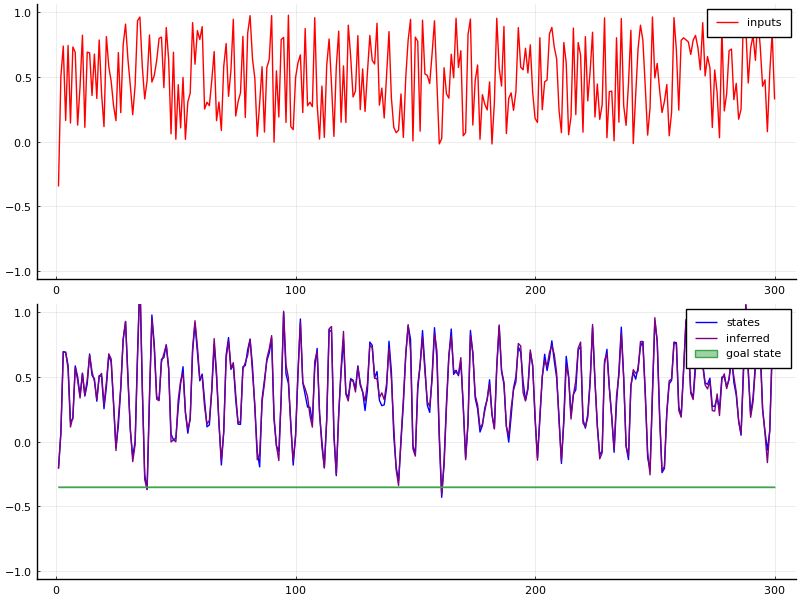

In [11]:
p1 = plot(1:T_trn, inputs, color="red", label="inputs", ylims=[-1, 1.])
p2 = plot(1:T_trn, states, color="blue", label="states", ylims=[-1, 1.])
plot!(1:T_trn, params_z[1][1,2:end], color="purple", label="inferred", ylims=[-1, 1.])
plot!(1:T_trn, repeat([goal_state[1]], outer=(1,T_trn))', ribbon=[goal_state[2], goal_state[2]], label="goal state")
plot(p1, p2, layout=(2,1), size=(800,600))

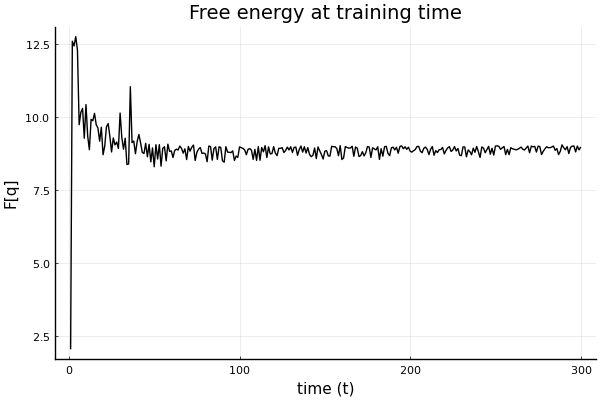

In [12]:
# Scatter FE during training
p24 = plot(1:T_trn, free_energy_trn[:,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy at training time")

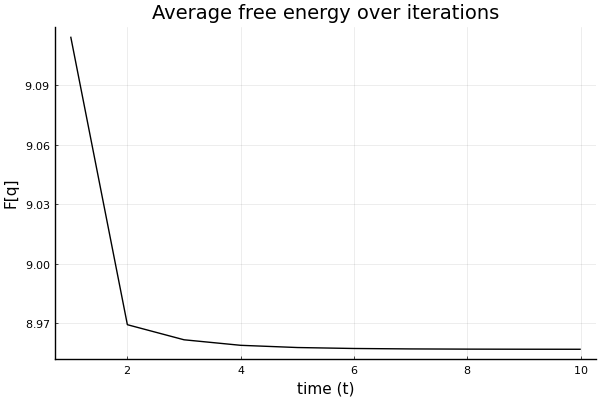

In [13]:
# Scatter FE during training
p34 = plot(mean(free_energy_trn, dims=1)', color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Average free energy over iterations")

### Validate identified system

We validate the identified system by computing simulation error on the validation set.

In [14]:
# Time horizon
T_val = 300

# Input signal
# input_val = [mean(sin.(t./ (0.1:.1:6 .*π))) for t in 1:T_val] 
input_val = sin.((1:T_val) ./ (6*π))

# Preallocate arrays
states_val = zeros(T_val,)
output_val = zeros(T_val,)

for k = 4:T_val
    output_val[k], states_val[k] = sim_sys(input_val[k], [states_val[k-1], states_val[k-2]], sys_params)
end

# Write to file

In [15]:
# Prediction graph
graph2 = FactorGraph()

# Autoregressive node
@RV z_pred ~ NLatentAutoregressiveX(placeholder(:θ, dims=(3,)), placeholder(:z_tmin1, dims=(2,)), placeholder(:η), placeholder(:u_t), placeholder(:ζ), g=g, id=:z_pred_t)

# Draw time-slice subgraph
# ForneyLab.draw(graph2)

# Inference algorithm
q2 = PosteriorFactorization(z_pred, ids=[:z_pred])
algo2 = messagePassingAlgorithm([z_pred], q2, free_energy=true)
source_code2 = algorithmSourceCode(algo2, free_energy=true)
eval(Meta.parse(source_code2));
# println(source_code2)

In [16]:
# Initialize free energy tracking array
free_energy_pred = zeros(T_val, num_iterations)

# Initialize future state arrays
params_preds = (zeros(2, T_val), repeat(.1 .*float(eye(2)), outer=(1,1,T_val)))

# Start simulation with known output
params_preds[1][1,2] = output_val[2]
params_preds[1][2,2] = output_val[1]

@showprogress for k = 3:T_val

    # Initialize marginals
    marginals[:z_pred] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_preds[1][:,k], w=params_preds[2][:,:,k])

    # Clamp data
    data = Dict(:u_t => input_val[k],
                :z_tmin1 => params_preds[1][:,k-1],
                :θ => params_θ[1][:,end],
                :η => params_η[1][end],
                :ζ => params_ζ[1][end]/params_ζ[2][end])

    # Iterate variational parameter updates
    for i = 1:num_iterations

        # Make prediction
        stepz_pred!(data, marginals)

        # Compute free energy
        free_energy_pred[k, i] = freeEnergy(data, marginals)
    end

    # Store current parameterizations of marginals
    params_preds[1][:,k] = ForneyLab.unsafeMean(marginals[:z_pred])
    params_preds[2][:,:,k] = marginals[:z_pred].params[:w]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


### Visualize results

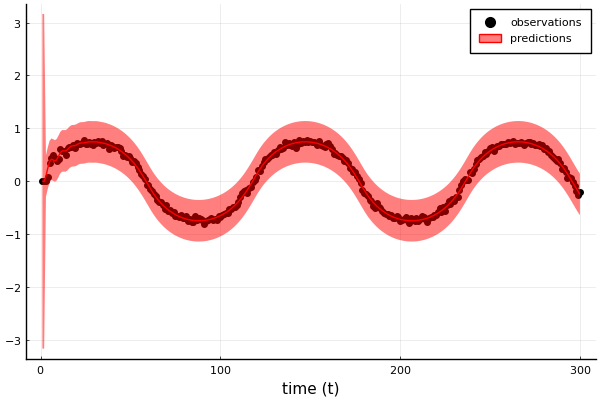

In [17]:
# Mean and std dev of predictions
predictions_mean = params_preds[1][1,:]
predictions_std = sqrt.(inv.(params_preds[2][1,1,:]))

# Plot predictions
p23 = scatter(1:T_val, output_val, label="observations", xlabel="time (t)", color="black")
plot!(1:T_val, predictions_mean, ribbon=[predictions_std, predictions_std], label="predictions", color="red")

In [18]:
Plots.savefig(p23, "figures/simulation_error.png")

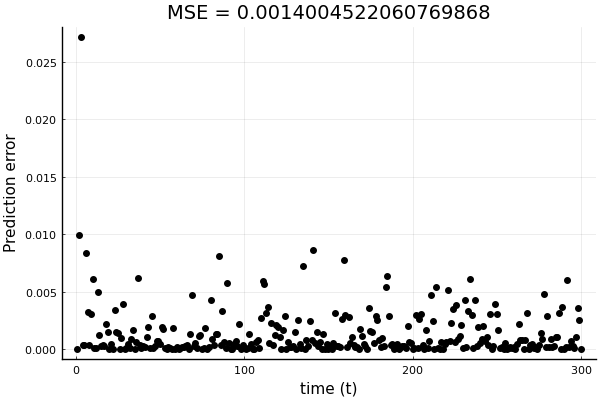

In [19]:
# Compute prediction error
sq_pred_error = (predictions_mean[2:end] .- output_val[2:end]).^2

# Simulation error
MSE_sim = mean(sq_pred_error)

# Scatter error over time
p24 = scatter(1:T_val, sq_pred_error, color="black", xlabel="time (t)", ylabel="Prediction error", label="")
title!("MSE = "*string(MSE_sim))

In [20]:
Plots.savefig(p24, "figures/pred-errors.png")

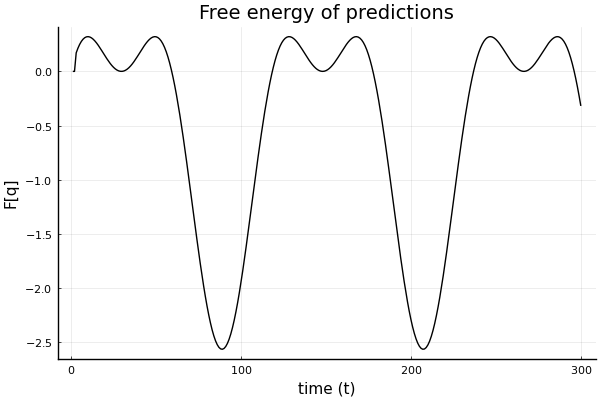

In [21]:
# Scatter FE during validation
p24 = plot(1:T_val, free_energy_pred[:,end], color="black", xlabel="time (t)", ylabel="F[q]", label="", title="Free energy of predictions")